# **App Store Reviews 분석**

![logo](./figs/App_Store_Logo.png)

## **목적**

App Store 에는 수많은 사람들이 앱에 관련해 리뷰를 달고 해당 앱에대해 평점을 매기고 있다. 많은 개발자들도 종종 리뷰를 보면서 향후 이용자와 소통을 하고 향후 앱 개발의 방향성을 탐색하고 고민하게 된다. 평소에 앱 스토어를 이용하면서 리뷰들이 정확하게 이 앱을 평가하고 있는지 혹은 앱들의 리뷰로 어떤 앱을 별점을 예측 할 수 있을 지 궁금해졌다. 그래서 이 프로젝트를 시작했다.

---

## **Part 1. 데이터 획득**

앱스토어 리뷰 데이터 크롤링을 위해서는 우선 스토어 페이지의 고유 ID를 알아야한다. 

이는 don9z [링크](https://github.com/don9z/appstore) 분의 App Store 조회를 위한 Tool를 사용해서 한국 앱스토어의 존재하는 무료/유료 포함된 약 4541개의 url 링크를 조회하여 ID부분만 추출해냈다. 중간에 페이지가 겹치는 id가 있어서 총 약 3600개의 앱이 있는 것으로 추정된다.

그 후 각 앱의 리뷰, 평점등 데이터는 앱스토어 고객리뷰로부터 [URL](https://itunes.apple.com/kr/rss/customerreviews/) 에서 크롤링 하여 DB에 저장했다. 10월 20일까지 작성된 리뷰 기준으로 DB 에 616,311 건의 데이터를 저장했고, 각 feature은 아래와 같다. 





|Feature Name| 설명 |
|:-:|:-|
|app_id| 앱스토어 페이지의 고유 ID| 
|app_name|앱 이름|
|review_id|리뷰 문서 ID|
|title|리뷰 문서 제목|
|author|리뷰 문서 저자|
|author_url|리뷰 url|
|version|앱 버젼|
|rating|리뷰 문서 저자가 이 앱에 대해 평가한 평점|
|review|리뷰 내용|
|category|앱 카테고리|

---

## **Part 2. 데이터 정제**

리뷰 분석을 위해서 한 문장을 최대한 작게 분할해야 한다. 그 이유는 우리는 보통 높은 단계의 사상이나 개념을 하위 단계의 요소로 세분화 하여 명확하게 정의 가능한다고 우리는 믿기 때문이다. 예를 들어 "나는 스타벅스에 가고 있어."라는 문장의 의미를 알고자 하려면 "나", "는", "스타벅스", "에", "가", "ㄴ다"의 의미를 각각 알고 이들을 조합해야 한다.

In [1]:
from utils import *
from konlpy.tag import Komoran
komoran = Komoran()
komoran.pos("나는 스타벅스에 간다")

[('나', 'NP'),
 ('는', 'JX'),
 ('스타벅스', 'NNP'),
 ('에', 'JKB'),
 ('가', 'VV'),
 ('ㄴ다', 'EC')]

따라서 문장을 분석하려면 문장을 구성하는 하위 개념인 단어 혹은 형태소로 자르게 된다. 보통 형태소의 기준으로 나눠서 쓴다. 그러나 여기서 문제가 생긴다. 문장 띄어쓰기나 오타가 나면 Komoran 형태소 분석기가 제대로 작동하지 않는 다는 점이다. 주로 문제가 발생하는 원인은 두 가지로 확인된다.
* 오타 및 축약어는 형태소 분석기 사전에 존재 하지 않기 때문에 Unknown(혹은 NA)로 인식
* 띄어쓰기가 제대로 안될 경우 전체 구문이 Unknown(혹은 NA)로 인식, 특히 'ㅠㅠ'같은 이모티콘(단순 자음 혹은 모음의 집합)과 문장이 붙어있으면 더욱 안되는 경우가 발생한다

In [2]:
input_file_path = './data/docs_jsonl_first_ma.txt'
app_id_list, ma_list = read_jsonl(input_file_path, only_ma=True)
UNK = Unknown_words()
unknowns = UNK.get_unknown_words(ma_list)
unknowns[:10]

Extracting unknowns:: 100%|██████████| 616311/616311 [00:04<00:00, 134894.29it/s]


Unknowns(중복제거): 86386, Total Unknown: 218180, Total MA: 1153009257


['끝나욬ㅋㅋ',
 '하던가ㅡㅡ',
 '뭘해옄ㅋㅋㅋㅋㅋㅋ아이폰',
 'ㅎㅎ좀더',
 '업뎃하고너무후회됨',
 '빡치네요후후',
 '줗아요!',
 '스테레우로',
 '아니겜도아닌게',
 'ㅡㄴ이']

### **띄어쓰기 문제**

주로 단일 자음, 모음으로 구성된 구문이 문장과 붙어 있으면 형태소 분석이 안되는 것이 띄어쓰기 문제다. 따라서 문장을 더 잘게 잘라서 해결하기로 했다.

예를 들어, "ㅠ개선좀해주세요ㅠㅠ"문장을 두 글자씩 검사해서 단일 자음 혹은 모음과 완전한 글자가 조합이 되면 띄어쓰기 하는 방법으로 띄어쓰기를 하였다.

* 작동방식:
> 0. 문장을 모두 한 글자로 쪼갠다. 
> 1. [반복]
> 1. Size가 2인 Window로 두 글자씩 검사한다. 
> 1. Window에 단일 자음/모음이 하나라도 들어가면 True 반환하고 idx를 기록한다.
> 1. [반복종료]
> 2. 문장의 첫글자와 마지막 글자 index가 없으면 index list에 추가한다. 
> 3. 얻어진 index list로 원래 문장을 단어로 조합하며 인덱스 사이사이에 공백 문자를 넣어 준다.

In [3]:
sentence = '제발 이것좀 어떻게 해주세요ㅜㅜㅜㅜㅜ진짜 찾아갈꺼에요ㅜㅜㅜ'
spacing = Spacing()
print('Before:', sentence)
print('After:', spacing.space_jamo(sentence))

Before: 제발 이것좀 어떻게 해주세요ㅜㅜㅜㅜㅜ진짜 찾아갈꺼에요ㅜㅜㅜ
After: 제발 이것좀 어떻게 해주세요 ㅜㅜㅜㅜㅜ 진짜 찾아갈꺼에요 ㅜㅜㅜ


본 프로젝트에서는 우선 띄어쓰기를 실행한 후에 형태소 분석을 진행하는 방향으로 한다.

### **오타 및 축약어**

오타와 축약어를 해결 하는 방법 중 하나는 형태소 분석 전에 사전에 지정한 단어를 등록하는 것이다. 그러나 이는 매우 노가다 성격이 짙은 작업이 된다. 그리고 우리가 모든 오타와 축약어 들을 사전에 수정할 수 없기에 후처리로 넘기는 것이 최선이다. 

단어의 후처리는 형태소 분석을 진행한 후에 제대로 되지 않은 단어들을 찾아서 바꿔주는 형태가 된다. 

In [4]:
komoran.pos('업뎃')

[('업뎃', 'NA')]

"업뎃"은 "업데이트"의 축약어다. 앱스토어 리뷰에 주로 나오는 단어들을 찾아서 규칙사전으로 기록 후에, 해당하는 단어를 찾아서 바꿔준다. Post_ma 클래스는 이를 처리하기 위해 만들어졌다. 형식은 다음과 같이 맞춰주고 update 메서드로 사전에 업데이트 해준다.

* 형식: [(바꾸고 싶은 단어와 품사들의 리스트들, 바꿔진 단어와 품사들의 리스트들), (...) ], 예를 들면 [([['업뎃', 'NA']], [['업데이트', 'NNG']])]

In [5]:
post_process = Post_ma('./data/post_ma_pairs/komoran.txt', tokenizer=komoran)

Load Complete! total 1 rules


In [6]:
file_path = './data/docs_jsonl_ma_komoran.txt'
app_id_list, app_name_list, cate_list, rating_list, ma_list = read_jsonl(file_path)
UNK = Unknown_words()
unknowns = UNK.get_unknown_words(ma_list)

Extracting unknowns:: 100%|██████████| 616311/616311 [00:08<00:00, 71298.82it/s]


Unknowns(중복제거): 39974, Total Unknown: 227479, Total MA: 1183924806


Unknown_word 클래스는 'NA', 혹은 'UNKNOWN'으로 분석된 형태소들을 추출해낸다. 동시에 이들이 있는 document 위치도 같이 기록하여 향후에 후처리시 같이 활용된다.

In [7]:
ma_list = post_process.replace_ma_docs(ma_list, UNK.unknown_loc_dict)
save_jsonl('./data/docs_jsonl_ma_komoran_after_processing.txt', 
           app_id_list, app_name_list, cate_list, rating_list, ma_list)

Saving documents: 100%|██████████| 616311/616311 [00:10<00:00, 56584.31it/s]


이 문서에서는 우선 '업뎃' 하나만 후처리 하였다.

---

## **Part 3. 데이터 분석**

### **A. 키워드 분석**

#### **문서 전체의 키워드 추출**

주요 품사인 명사, 동사, 형용사, 부사, 어근을 추출해서 문서에 어떤 키워드가 있는지 살펴본다. 주로 '구매, 어플, 좋다, 삭제' 어플에 관련된 단어들이 많다고 생각된다. 또한, 조금더 시각적으로 잘 보기 위해서 워드 클라우드로 살펴 보았다.

In [8]:
from analysis import * 
from word_cloud import *
file_path = './data/docs_jsonl_ma_komoran_after_processing.txt'
major_pos = ["NNG", "NNP", "NP", "XR", "VV", "VA", "MAG", "MAJ"]

Counting Words...: 100%|██████████| 616311/616311 [00:18<00:00, 32496.37it/s]


최다 빈도수 단어 TOP 10
[('하다/VV', 158944),
 ('좋다/VA', 155096),
 ('있다/VV', 114100),
 ('삭제/NNG', 86239),
 ('쓰다/VV', 81855),
 ('되다/VV', 80073),
 ('구매/NNG', 73781),
 ('안/NNG', 73476),
 ('앱/NNP', 71114),
 ('어플/NNP', 70991)]
총 단어수: 35758


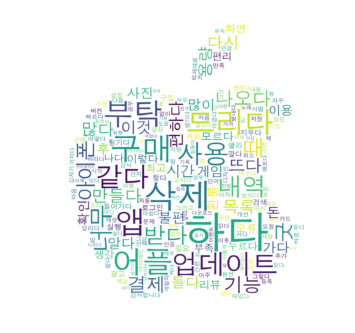

In [9]:
make_dict, app_id_list, ma_list = make_keyword_dict(file_path, major_pos, komoran_option=True, 
                                                    only_ma=True)
WC(make_dict.word_count, './figs/apple_logo_black.png', option_pretty=True)

#### **App 별로 키워드 추출하기**

전체 문서의 키워드를 보고나니 각 앱별로의 키워드가 있는지 궁금해졌다. 따라서 우선 주요 품사를 추출해 만든 사전으로 있는 단어만 추출하도록 문서 필터링을 하고, "용어 빈도 역문헌 빈도(TF-IDF)"에 근거한 키워드 추출을 진행했다.

TF-IDF 방법을 선택한 이유는 단순 용어 빈도에 근거해 추출한 키워드는 특정성이 부족기 때문이다. 특정성이 높은 용어들의 특징은 상대적으로 적게 쓰인다는 것이다. 따라서 어떤 용어가 하나의 문헌에서도 많이 사용되고 그 문헌이 속한 전체 문헌 집합에 속한 다수의 다른 문헌들에서 널리 쓰였다면 이 용어는 특정성이 떨어지는 용어이다.

예를 들어 모든 앱 리뷰에 "좋다" 라는 단어가 들어갔다고 생각해보면, "좋다"라는 단어는 어떤 문서의 특정 키워드라고 말하기 어려울 것이다. 

TF-IDF는 아래와 같은 방법으로 계산 된다. 

$$tfidf(D, d, t) = tf(d, t) \times idf(D, t)$$

여기서 $tf(d, t)$ 는 용어빈도(term of frequency)로써 용어가 한 문서에 등장한 횟수고, $idf(D, t)$ 는 역문헌 빈도(inverse document frequency)로써 아래와 같이 계산한다.

$$idf(D, t)= \log\frac{|D|}{|\{ d \in D, t \in d \}|+1}$$

분자 $|D|$ 는 문서의 갯수, 분모 $|\{d \in D, t \in d \}|$ 는 전체 문서에서 어떤 용어가 들어간 문서 갯수다. 분모에 0이 들어갈 수도 있으니 1을 더해서 이를 방지해준다(smoothing).

최종적으로 $tf-idf$ 를 출력할때 문서별로 L2 normalize를 해줌으로써 0과 1사이의 값을 만들어준다. 따라서 어떤 문서에서 어떤 용어가 1에 가까운 값을 가지면 특징성이 큰 용어이며, 반대로 0에 가까우면 어디서든지 출현하는 단어라고 말할 수 있다.

In [10]:
save_file_path = './data/docs_jsonl_ma_by_app_id.txt'

In [11]:
data_processing_keyword_extract(file_path, save_file_path, major_pos)

Saving documents: 100%|██████████| 3599/3599 [00:00<00:00, 3756.78it/s]


In [12]:
keyword_dict, app_id_list, cate_list, app_name_list, _ = get_key_word(save_file_path, 
                                                                      vectorizer=TfidfVectorizer)

Extracting...: 100%|██████████| 3599/3599 [00:03<00:00, 1074.74it/s]


In [13]:
idx = np.random.randint(0, len(app_id_list))
print('App_name:', app_name_list[idx])
print('Category:', cate_list[idx])
print('Keywords:', [w.split('/')[0] for w in keyword_dict[app_id_list[idx]]])

App_name: 여행노트 : 코스대로 기록하는 여행 어플
Category: 여행
Keywords: ['여행', '어플', '노트', '여행기', '추억', '때', '갈', '사진', '정말', '기록']


키워드 추출 결과를 보면 이 앱이 어떤 것을 설명하고 있는지 잘 알 수가 있다. 그러나 가끔 '구매내역 삭제 부탁' 관련 글이 주요 키워드로 나오는 경우가 있는데, 이런 앱들을 살펴보니 아래그림과 같은 리뷰들만 있었다.

<img src="./figs/구매내역삭제.jpg" alt="Drawing" style="width: 400px;"/>

이와관련해서 재밌는 기사도 있었다.

[<"앱스토어 구매내역 삭제요청에 분노한(?) 스타트업이 서명운동을 벌이고 있다">](http://www.huffingtonpost.kr/2016/06/01/story_n_10234524.html)

### **B. 문서 군집화**

리뷰에서 추출해낸 대표 키워드가 앱을 잘 설명하고 있다는 것을 알고난 후, 앱 리뷰만으로 클러스터링하여, 어떤 리뷰의 군집형태가 있는지 살펴보았다. 

또한 클러스터링된 앱의 카테고리가 같이 묶이는지 확인해보았다. 이 궁금증이 생긴 이유는 리뷰에 앱에 관련된 정보가 많이 담겨 있을 것이라고 생각했기 때문이였다. (그러나 결과를 보고 이는 잘못된 생각이라는 것을 깨달았다.)

따라서 처음 카테고리 분류를 24개로 진행해보았다.

이번에도 주요 품사를 사용해서 tf-idf matrix를 만들어내고 이를 활용해서 클러스터링을 진행하였다. 또한, 데이터 양이 워낙 크다보니 batch KMeans를 사용하여 조금씩 업데이트 하였다.

In [14]:
from Clustering import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
df, df_, df_raw = main_cluster(vectorizer=TfidfVectorizer, n_cluster=24, n_max=10)

Reading Files: 100%|██████████| 3599/3599 [00:01<00:00, 2125.17it/s]


Done!


"구매", "내역", "목록", "삭제", "부탁" 단어가 들어간 단어는 중심단어에 파란색으로, 앱의 갯수에서 10개 이상 클러스터링 된 곳에는 빨간색으로 표시하였다.

In [15]:
(df.style.set_properties(**{'max-width': '600px', 'font-size': '6pt'})\
    .set_table_styles(magnify())\
    .applymap(color_red, subset=['앱의 갯수'])\
    .applymap(color_blue, subset=list(df.columns[range(10)])))

,키워드1,키워드2,키워드3,키워드4,키워드5,키워드6,키워드7,키워드8,키워드9,키워드10,앱의 갯수,실제 카테고리들
1,운동,인식,턱걸이,주머니,카운트,세트,풀,한국어,잘,체계,1,['건강 및 피트니스']
2,삭제,안,구매,앱,부탁,내역,업데이트,어플,안,좀,388,['여행' '소셜 네트워킹' '유틸리티' '내비게이션' '엔터테인먼트' '뉴스' '금융' '비즈니스' '의학' '음식 및 음료' '생산성' '도서' '라이프 스타일' '음악' '스포츠' '참고' '건강 및 피트니스' '교육' '게임' '사진 및 비디오' '날씨' '카탈로그']
3,삭제,구매,내역,부탁,목록,용량,부족,좀,안,어플,437,['유틸리티' '뉴스' '여행' '소셜 네트워킹' '비즈니스' '라이프 스타일' '스포츠' '생산성' '사진 및 비디오' '의학' '엔터테인먼트' '카탈로그' '참고' '금융' '내비게이션' '도서' '음악' '건강 및 피트니스' '게임' '교육' '잡지 및 신문' '음식 및 음료' '날씨']
4,필터,사진,카메라,결제,색감,어플,너무,아날로그,필름,기능,44,['사진 및 비디오']
5,잘,소리,굿,때,앱,어플,사용,잠,정말,너무,112,['건강 및 피트니스' 'NaN' '의학' '뉴스' '내비게이션' '음악' '유틸리티' '엔터테인먼트' '라이프 스타일' '참고' '교육' '여행' '소셜 네트워킹' '사진 및 비디오' '날씨' '생산성' '금융' '비즈니스' '카탈로그' '스포츠']
6,악기,녹음,시퀀서,밴드,미디,작곡,비트매니아,멜로디,어플,개러지밴드,1,['음악']
7,게임,굿,너무,안,재미,좀,업데이트,시간,꿀,안,164,['엔터테인먼트' '게임' '라이프 스타일' '소셜 네트워킹' '교육']
8,캘린더,일정,위젯,달력,음력,기능,앱,사용,잘,어플,24,['생산성' '유틸리티' '라이프 스타일' '비즈니스']
9,책,앱,안,도서관,대출,도서,어플,구매,업데이트,전자책,40,['도서' '생산성' '참고']
10,안,업데이트,어플,앱,사용,잘,기능,좀,안,때,290,['생산성' '소셜 네트워킹' '금융' '비즈니스' '유틸리티' '참고' '교육' '스포츠' 'NaN' '뉴스' '도서' '건강 및 피트니스' '엔터테인먼트' '라이프 스타일' '카탈로그' '사진 및 비디오' '음악' '날씨' '내비게이션' '의학' '여행']


표의 결과를 보고 리뷰로 카테고리를 클러스터링 혹은 분류하는 문제를 풀 수 없다는 것을 깨달았다. 문제 설정을 잘못 한거다. 애초에 리뷰는 어떤 앱을 사용한 후기인데 그 앱에 대한 정보가 담긴 글보다는 "좋다, 나쁘다" 식의 평가글이 더 많을 것이기 때문이다.

아래 표는 어느 카테고리 앱들이 클러스터링으로 가장 많이 들어갔는지 갯수를 세보았다. 

노란색으로 표시된 부분은 각 클러스터에서 대표가 되는 카테고리(열을 기준으로 제일 큰 숫자), 즉 가장 많이 클러스터링된 카테고리다. 빨간색 글씨는 각 카테고리별로 가장 많은 앱들이 클러스터링 된 곳으로(행을 기준으로 제일 큰 숫자), 노란색 바탕과 빨간색 글씨가 겹친 부분에서 행과 열의 숫자가 상대적으로 적은 편이면 카테고리 클러스터를 기대 했을 때 리뷰로 클러스터가 잘 된 곳이라고 말 할 수 있다. 

앱스토어에서 게임 리뷰가 가장 많은 편이라서 게임 앱의 클러스터링은 그 특징이 잘 나타나서 군집이 잘 되어있다. 또한 사진 및 비디오 카테고리 또한 그 특징이 잘 나타나는데, "사진", "필터", "카메라" 등 단어들이 그 특징이다. 

나머지 클러스터가 잘 안된 것은 중심점이 되는 단어가 카테고리의 특징을 잘 나타나지 못하기 때문이다. 각각의 클러스터를 보면 중심이 되는 단어를 보면 "어플, 앱, 잘, 사용, 안" 등 이런 식이다. 또한 "삭제, 구매, 내역, 부탁, 목록" 단어들이 중심단어로 나타났는데, 이는 위에서 보았던 "구매목록 삭제"를 부탁하는 리뷰들이 많이 모여 있는 것으로 파악된다. 

따라서 리뷰로 카테고리를 클러스터링 할 수는 없지만 "구매목록 삭제" 리뷰들을 Detecting 할 수 있을 것이라고 생각된다. 예를 들어 2, 3번 클러스터링이 주로 모여있다. 또한 흥미로운 것은 10, 13, 24번 클러스터링은 키워드와 등장 빈도가 각 카테고리에서 많은 편인 것을 보았을 때 사용에 대한 평가라고 추측한다.

In [16]:
(df_.fillna(0).astype(np.int).style.applymap(color_zero_white)\
    .highlight_max(axis=0, color='yellow')\
    .apply(highlight_max_red, color='red', axis=1))

cluster,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
category,,,,,,,,,,,,,,,,,,,,,,,,
NaN,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,9,0
건강 및 피트니스,1,10,20,0,28,0,0,0,0,5,0,2,16,39,0,0,8,0,1,0,0,6,53,3
게임,0,3,13,0,0,0,150,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,25,3
교육,0,22,14,0,3,0,2,0,0,26,0,4,0,0,56,0,0,1,2,0,1,0,42,2
금융,0,69,13,0,2,0,0,0,0,27,0,2,3,0,0,0,0,0,0,0,0,0,51,7
날씨,0,2,7,0,1,0,0,0,0,1,57,0,0,0,0,0,0,0,3,0,0,0,47,2
내비게이션,0,38,19,0,4,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,88,16
뉴스,0,4,13,0,3,0,0,0,0,6,0,2,0,0,0,31,1,0,4,1,1,0,54,0
도서,0,16,19,0,0,0,0,0,37,23,0,0,0,0,6,0,0,0,7,0,0,0,65,6


### **C. 문서 분류**

각 앱에는 리뷰와 더불어 사용자가 메긴 평점이 같이 있다. 1~5점으로 1은 최악, 5는 최고 평점이다. 앱에대한 평가가 좋으면 리뷰도 좋고, 평점도 좋게 주었을 것이라고 생각된다. 따라서 여기서는 사용자가 평가한 앱에 대한 평점이 리뷰와 정의 상관관계가 있다고 가정하고 리뷰를 Input으로 하여 평점을 예측해보기로 했다.

#### ** Navie Bayesian 을 통한 평점 분류**

하나의 리뷰를 보면, 리뷰 A는 문장내에 단어들의 조합이다 $[a_1, a_2 ,\cdots, a_n]$. B는 rating점수라고 정한다. 우리는 A를 통해 B를 예측하려고 한다. 이는 A가 주어졌을 때, B가 나올 확률을 구하면 되는 것이다. 

따라서, 베이지안 룰을 활용하면 $P(B|A) = \frac{P(A,B)}{P(A)} = \frac{P(A|B)P(B)}{P(A)}$가 성립하는데, $P(B)$는 사전 확률로 문서내에 각 rating이 나온 횟수로 측정 , $P(A|B)$는 Likelihood다. 평점이 주어졌을 때, 리뷰 A가 나올 확률이다.

Chain rule를 활용하면 Likelihood $\times$ prior 은 아래와 같이 된다.

> $P(a_1, a_2 ,\cdots, a_n, B) \\ 
 = P(a_1, a_2 ,\cdots, a_n|B)P(B) \\
 = P(a_2, \cdots, a_n|B, a_1)P(a_1|B)P(B) \\
 = \cdots = P(a_n|B, a_1, \cdots, a_{n-1}) \cdots P(a_1|B)P(B)$

여기서 $P(B)$를 제외한 부분은 각각의 조건하에 나타나는 단어의 조건부 확률이다. 주요 품사만 뽑아도 단어가 3만개 이상은 되는데 이들을 조합해서 다시 모든 단어들에 대한 조건부 확률은 구해야 한다. 이는 상당히 많은 수를 계산해야 하기 때문에 Navie가정을 하여($a_i$는 각기 다른 $a_i$과 독립이며, B에 대하여 조건부 독립이다) 계산하게 된다. 즉,

> $P(a_1|B) = P(a_1|B)\\
P(a_2|B, a_1) = P(a_2|B)\\
\quad \vdots \\
P(a_n|B, a_1, \cdots, a_{n-1}) = P(a_n|B)$

가 되는 것이고 종합하게 되면 $ P(a_1, a_2 ,\cdots, a_n, B) = \prod_{i=1}^{n}{P(a_i|B)}P(B)$ 가 된다.

따라서 나이브한 가정하에 어떤 리뷰 A 가 주어졌을 때 B 라는 평점이 나올 확률은 $P(B|A) \propto \prod_{i=1}^{n}{P(a_i|B)}P(B)$ 의 관계가 있다라는 것을 알 수 있다.

$P(a_i|B) = \frac{n_{a_i}}{n_B}$ 는 $B$ 평점이 매겨진 문서들에서 단어 $a_i$가 등장한 문서 횟수를 $B$ 평점 문서 총 갯수로 나눠줌으로써 계산된다.

In [17]:
from NaiveBayesian import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_curve
file_path = './data/docs_jsonl_ma_komoran_after_processing.txt'
save_file_path_NB = './data/docs_jsonl_ma_NB.txt'
major_pos = ["NNG", "NNP", "NP", "XR", "VV", "VA", "MAG", "MAJ"] + ['SL', 'SH', 'SN']

In [18]:
NB_data_processing(file_path, save_file_path=save_file_path_NB, major_pos=major_pos)

Saving documents: 100%|██████████| 566125/566125 [00:04<00:00, 117106.13it/s]


결과로 약 62.97%의 분류 성능을 보여주었다. 정확률(precision)를 같이 살펴보면 주로 1점과 5점의 평점은 상대적으로 예측을 맞추는 편이다. 그러나 기존에 평점 5점인 문서가 다른 문서들에 비해 우월하게 많은 것을 감안해야한다. 총 141532개의 테스트 문서중에서 약 50% 이상이 5점 이고, 약 25%가 1점이고 나머지는 2~4점이다. 그만큼 5점의 리뷰들이 더 분류를 잘 할 가능성이 높다는 뜻이다. 5점의 재현률(recall)이 90% 가까이 되는 이유도 5점 리뷰가 많기도 하고, 5점으로 예측할 가능성도 높기 때문이다. 

* **정확률(Precision)**: 클래스에 속한다고 예측한 샘플 중 실제로 클래스에 속하는 샘플 수의 비율, 예를 들어 평점 5점의 리뷰를 10개 예측 했고 실제로 예측 중에 6개가 실제로 평점이 5점이면, 0.6의 정확률이 되는 것이다. 
* **재현율(Recall)**: 실제 클래스에 속한 샘플 중에 클래스에 속한다고 출력한 샘플의 수의 비율, 예를 들어 평점 5점의 리뷰가 실제로 20개가 있고 예측한 문서가 6개였다면, 0.3의 재현율이 계산된다. 

Reading Files: 100%|██████████| 566125/566125 [00:07<00:00, 71970.76it/s] 


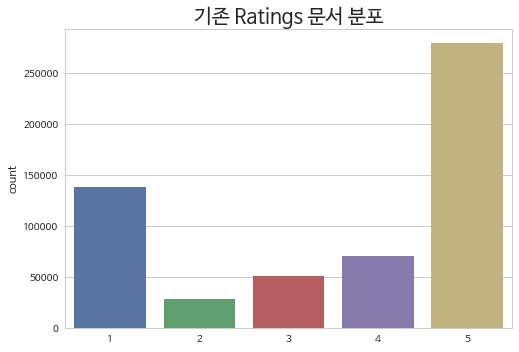

**making confusion matrix**
Accurary: 62.9794%
Classification Report
             precision    recall  f1-score   support

          1       0.61      0.70      0.65     34733
          2       0.00      0.00      0.00      6984
          3       0.37      0.00      0.01     12581
          4       0.32      0.01      0.02     17276
          5       0.64      0.92      0.76     69958

avg / total       0.54      0.63      0.54    141532



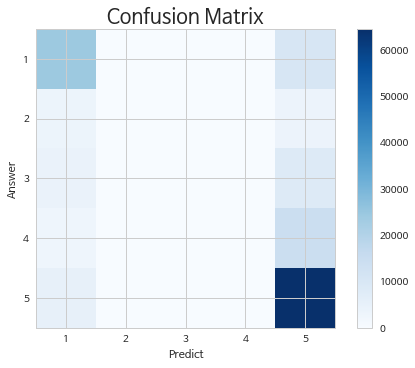

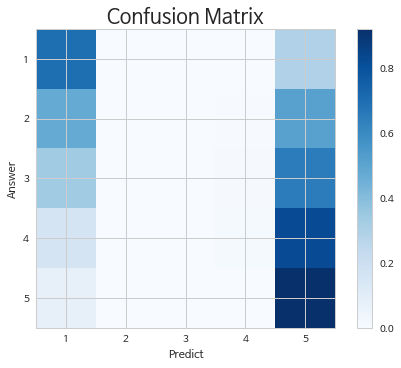

In [19]:
NB_main('./data/docs_jsonl_ma_NB.txt', TfidfVectorizer, ngram_range=(1, 1))

In [3]:
NB_CVtest('./data/docs_jsonl_ma_NB.txt', n_split=3)

Reading Files: 100%|██████████| 566125/566125 [00:04<00:00, 122735.58it/s]


Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 45.4min finished


Best score: 0.6282287480680062
Best parameter set:
	vect__max_features: None
	vect__ngram_range: (1, 1)
	vect__use_idf: False
	vect__smooth_idf: True
	vect__sublinear_tf: True
	vect__norm: l2
	mb__alpha: 1.0


이 결과로 유추 할 수 있는 것은 사람들이 리뷰를 쓸때 주로 1점과 5점을 주는 편이며, 성능이 좋지 못한 이유는 첫째로, 2~4점의 데이터가 다른 점수에 비해 상당히 부족한 편이다. 둘째로, "사용자가 평가한 앱에 대한 **평점**이 **리뷰**사이에 선형적인 정의 상관관계가 있다"라는 가정이 틀린것으로 생각된다. 그 이유는 5점 리뷰에 많이 들어간 단어가 1점에도 똑같이 들어가는 경우가 많기 때문이다. 

5점 문서와 1점 문서를 각각 tf-idf 기준과 주요 품사별로 추출해서 단어의 Count순으로 표를 만들어 보았다(하단 첫번째 표). 10위 권 안으로 겹치는 단어들이 5개가 존재한다. 50위 권으로 보면 27개나 존재한다.

그러나 Count기준 50위안으로 공통단어를 제외하여 살펴보면 각 평점의 문서만의 특징이 있었다(하단 두번째 표). 평점이 5점인 문서에는 "굿, 편리, 최고, 감사합니다, 유용, 깔끔, 만족" 등등 단어들이 등장했고, 1점인 문서에는 "왜, 환불, 돈, 불편, 짜증, 오류, 개선" 등등의 단어들이 나타났다. 

In [20]:
table, df = main_specific(n_common=50)

Extracting...: 100%|██████████| 278917/278917 [04:44<00:00, 980.24it/s] 


In [21]:
df = df.head(10)
df.style.apply(color_red_if_duplicated, axis=1, 
               words=df.loc[df.iloc[:, 0].isin(df.iloc[:, 2]), '5점 문서'].values.tolist())

,5점 문서,Count_5,1점 문서,Count_1
1,어플/NNP,37569,안/NNG,39104
2,잘/MAG,35045,업데이트/NNG,25361
3,앱/NNP,32768,앱/NNP,23051
4,삭제/NNG,30489,삭제/NNG,22853
5,구매/NNG,29618,안/MAG,19091
6,굿/NNG,27589,어플/NNP,18945
7,부탁/NNG,26999,구매/NNG,16405
8,사용/NNG,26246,왜/MAG,16196
9,너무/MAG,25932,좀/MAG,14282
10,정말/MAG,20460,부탁/NNG,13713


In [22]:
table

,5점 문서,Count_5,1점 문서,Count_1
1,굿/NNG,27589,왜/MAG,16196
2,정말/MAG,20460,환불/NNG,10041
3,최고/NNG,12267,다시/MAG,9683
4,용량/NNG,10195,뭐/NP,9669
5,편리/NNG,10187,계속/MAG,9095
6,많이/MAG,10165,로그인/NNG,7945
7,감사합니다/NNP,9696,돈/NNG,7895
8,추천/NNG,9059,오류/NNG,7130
9,유용/XR,8788,실행/NNG,6809
10,이용/NNG,8777,후/NNG,6247


---

## **Part 4. 결론 및 향후 과제**

### **결론**
앱 리뷰의 주요 키워드 추출, 클러스터링과 평점을 통한 분류를 시도해 보았다. 이를 통해 얻은 결론은 아래와 같다. 
1. 앱 스토어 리뷰 데이터를 사용하려면 전처리에서 꽤 많은 처리가 필요하며, 띄어쓰기, 형태소 분석과 단어 후처리에 많은 시간을 쏟아야 한다. 
2. 주요 키워드 추출로 앱의 내용을 설명 할 수 있다는 점을 발견 했다. 그러나 가끔 "구매내역 삭제 부탁" 관련 글들이 등장하는 경향을 보였다. 
3. 문서 클러스터링의 경우 리뷰로 카테고리를 클러스터링 혹은 분류하는 문제를 풀 수 없다. 이는 각 리뷰마다 앱의 기능이 담긴 내용은  적으며 주로 앱에 대한 평가의 단어가 많기 때문이다. 그중에서도 게임, 사진 및 비디오 카테고리는 리뷰에서의 관련 단어가 많이 나온 편이라 특징이 잘 나타나서 분류가 잘 되는 편이다. 이중에서 흥미로운 것은 "구매내역 삭제 부탁" 리뷰가 존재하는 앱들도 한 곳으로 클러스터링 됐다는 것이다. 이를 이용해 "구매내역 삭제 부탁" 앱들을 체크해 볼 수가 있다.
4. 나이브 베이지안 모델의 정확도는 약 62.97%이며 1점과 5점의 리뷰를 잘 예측하는 편이다. 성능이 62%정도 나온 이유는 첫째로, 사람들이 리뷰를 쓸때 주로 1점과 5점을 주는 편이여서 데이터에 불균형이 있다. 둘째로 "사용자가 평가한 앱에 대한 평점이 리뷰와 정의 상관관계가 있다"라는 것은 부분적으로 맞지만, 완전이 선형적인 관계는 아니다. 1점과 5점의 리뷰에서 각각의 특징적인 단어들도 나타 났지만, 공통적인 단어들도 많이 있기에 분류 성능이 떨어진다.


### **향후과제**
1. 띄어쓰기 모델 발전 시키기
2. 딥러닝을 활용한 문서 분류
3. (장기)카테고리와 키워드를 설정하면 앱스토어 리뷰를 쓰는 챗봇을 만들자! (seq2seq)